# Abrindo a caixa preta dos algoritmos de Machine Learning

Nem sempre os algoritimos mais simples são os que trazem melhores resultados. Muitas vezes é necessário o usod e algorítmos mais complexos mas que são verdadeiras caixas oretas - não sabemos como ele trabalha. 
<br>
Vamos trabalhar com um dataset para elaborar melhor esse problema.
<br>
Neste dataset há dados de trabalhadores americanos. Usaremos ML para prever qual a probabilidade deles ganharam mais de US$ 50mil.

In [4]:
!pip install pydotplus

  Running setup.py bdist_wheel for pydotplus: started
  Running setup.py bdist_wheel for pydotplus: finished with status 'done'
  Stored in directory: C:\Users\Marcos\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [5]:
import xgboost
import shap
import numpy as np
import matplotlib.pylab as plz
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import warnings
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from io import StringIO


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
    
%matplotlib inline
# print the JS visualization code to the notebook
shap.initjs()

# 1 - Load dataset

In [6]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [12]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [28]:
y_display

array([False, False, False, ..., False, False,  True])

In [19]:
X.corr().round(2)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
Age,1.00,0.00,0.04,-0.27,-0.02,0.09,0.03,0.09,0.08,0.06,0.07,-0.00
Workclass,0.00,1.00,0.05,-0.06,0.25,0.04,0.05,0.10,0.03,0.01,0.14,-0.01
Education-Num,0.04,0.05,1.00,-0.07,0.11,0.02,0.03,0.01,0.12,0.08,0.15,0.05
Marital Status,-0.27,-0.06,-0.07,1.00,-0.01,-0.22,-0.07,-0.13,-0.04,-0.03,-0.19,-0.02
Occupation,-0.02,0.25,0.11,-0.01,1.00,0.02,0.01,0.08,0.03,0.02,0.08,-0.01
Relationship,0.09,0.04,0.02,-0.22,0.02,1.00,0.06,0.33,0.06,0.05,0.07,0.00
Race,0.03,0.05,0.03,-0.07,0.01,0.06,1.00,0.09,0.01,0.02,0.04,0.14
Sex,0.09,0.10,0.01,-0.13,0.08,0.33,0.09,1.00,0.05,0.05,0.23,-0.01
Capital Gain,0.08,0.03,0.12,-0.04,0.03,0.06,0.01,0.05,1.00,-0.03,0.08,-0.00
Capital Loss,0.06,0.01,0.08,-0.03,0.02,0.05,0.02,0.05,-0.03,1.00,0.05,0.00


In [29]:
df = X.copy(deep=True)

df['target'] = y

In [31]:
df.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,target
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39,False
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39,False
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39,False
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39,False
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5,False


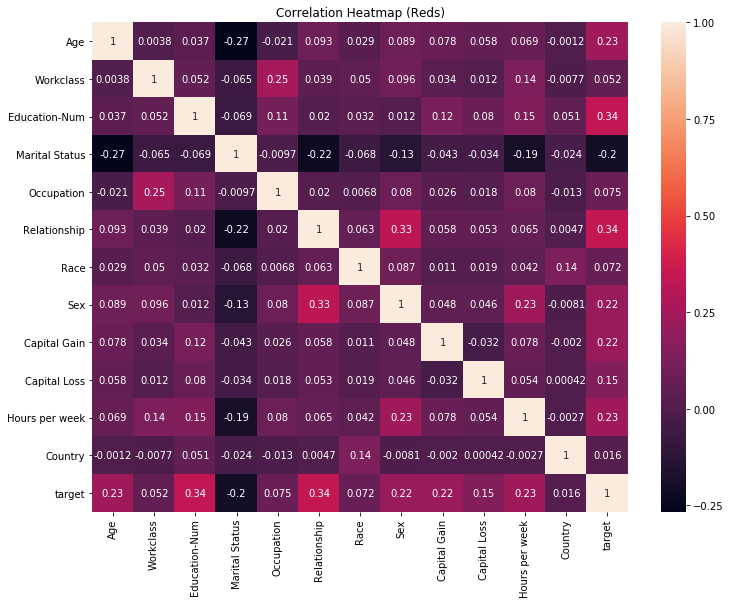

In [32]:
plt.subplots(figsize=(12,9))
ax = plt.axes()
ax.set_title("Correlation Heatmap (Reds)")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)

plt.show()

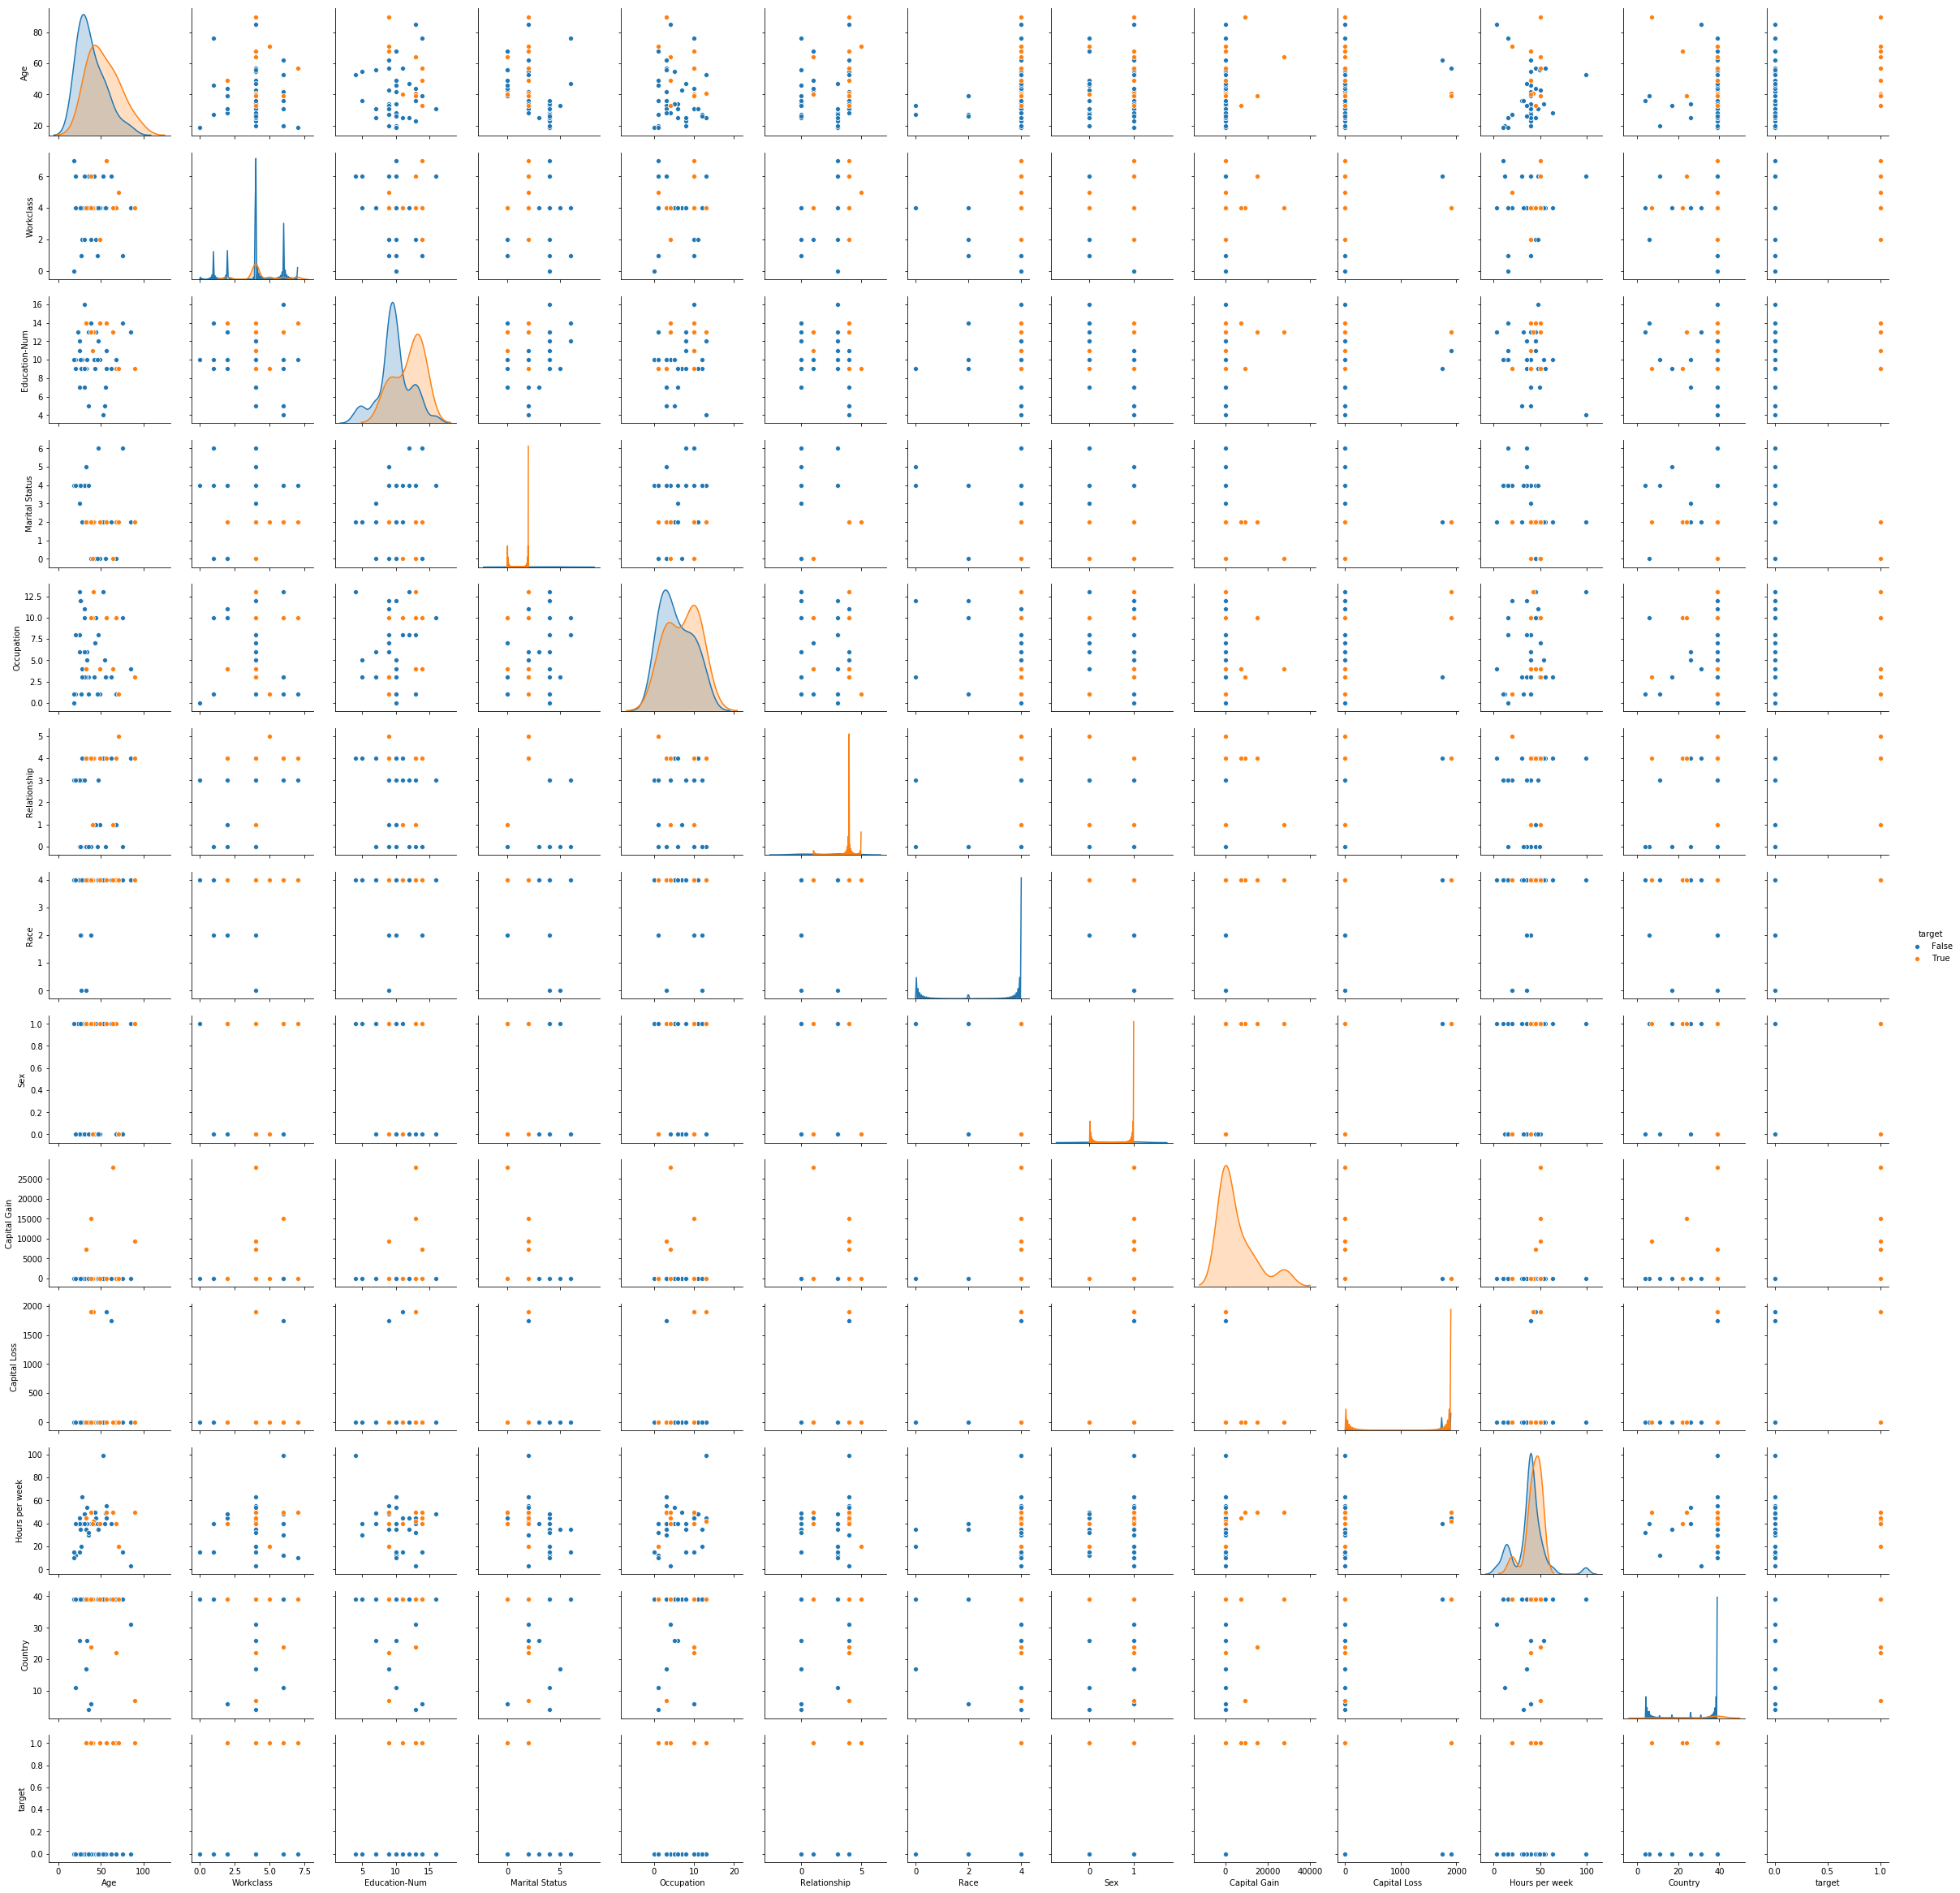

In [33]:
sns.pairplot(df.sample(50), hue='target')

# 2 - Entendendo o impacto das variáveis

In [34]:
df.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,target
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39,False
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39,False
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39,False
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39,False
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5,False


In [35]:
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '')

In [36]:
df.head()

,Age,Workclass,EducationNum,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,Hoursperweek,Country,target
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39,False
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39,False
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39,False
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39,False
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5,False


In [37]:
list(df)

['Age',
 'Workclass',
 'EducationNum',
 'MaritalStatus',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'CapitalGain',
 'CapitalLoss',
 'Hoursperweek',
 'Country',
 'target']

In [41]:
df['target'].value_counts()

False    24720
True      7841
Name: target, dtype: int64

In [42]:
df['target'] = df['target'].astype(int) 

In [43]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

In [44]:
function = '''
target ~ Age
+ Workclass 
+ EducationNum 
+ MaritalStatus
+ C(Occupation)
+ C(Relationship) 
+ C(Race)
+ C(Sex)
+ CapitalGain
+ CapitalLoss 
+ Hoursperweek
+ C(Country)'''

results = smf.ols(function, data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     254.2
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:35:15   Log-Likelihood:                -11262.
No. Observations:               32561   AIC:                         2.267e+04
Df Residuals:                   32488   BIC:                         2.328e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6428 

strong multicollinearity or other numerical problems.


# 3 - Usando modelos de arvore de decisão para entender o impacto e a relação entre as variáveis do dataset de renda.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dtr = DecisionTreeClassifier(max_depth=3)
dtr.fit(X_train,y_train)
yhat = dtr.predict(X_test)
yhat_proba = 1-dtr.predict_proba(X_test)[:,:1]
yhat_proba_train = 1-dtr.predict_proba(X_train)[:,:1]

precision = metrics.precision_score(y_test,yhat)
recall = metrics.recall_score(y_test,yhat)
auc = metrics.roc_auc_score(y_test, yhat_proba)

print(f'Precisao: {round(precision,4)}, Recall:{round(recall,4)}, AUC:{round(auc,4)}')

Precisao: 0.7628, Recall:0.5043, AUC:0.8596


# 4 - Plotando as métricas

Confusion matrix, without normalization
[[7796  400]
 [1264 1286]]


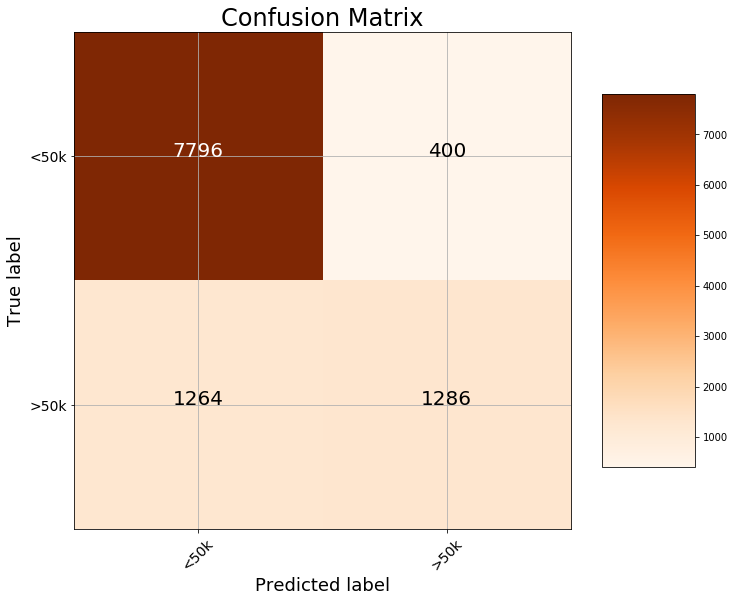

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, yhat)

plot_confusion_matrix(cm, classes = ['<50k', '>50k'],
                      title = 'Confusion Matrix')

plt.savefig('cm.png')

AUC:0.8596


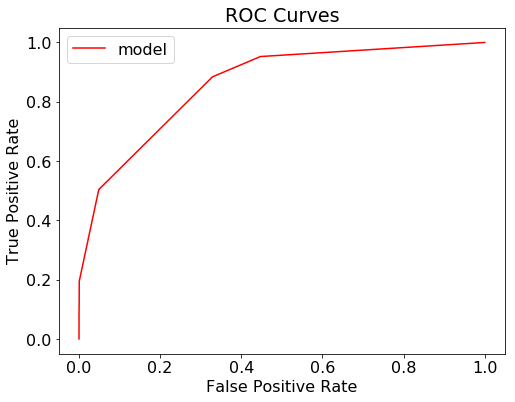

In [47]:
# Calculate false positive rates and true positive rates
model_fpr, model_tpr, _ = metrics.roc_curve(y_test, yhat_proba)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
print(f'AUC:{round(auc,4)}')
plt.show();

In [53]:
!pip install graphviz

In [54]:
dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=list(X))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found